# Predicting Yelp Star Ratings

In this little exercise, I am going to have a look at the distribution of Yelp ratings (1 to 5 stars) and their correlations to business and user attributes. Eventually I am testing several ML algorithms to predict a rating from business / user attributes and the review test.

### Import statements

In [1]:
%matplotlib inline

import os, sys
import numpy as np
import scipy as sp
import pandas as pd
import random
import re

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
#matplotlib.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
def format_column_names(dataFrame):
    dataFrame.columns = dataFrame.columns.str.replace('[^\w.]+','_')
    dataFrame.columns = dataFrame.columns.str.lower()
    
pd.options.display.max_seq_items = 500

### User Settings

In [3]:
# The fraction (random sample) of the review dataset, which is to be parsed
# Table joining and text vectorization is demanding in terms of memory and cpu load,
# so I recommend a value <= 0.1!
REVIEW_FRAC = 0.02

### Verify the source directory

In [4]:
# Set the source directory for the input csv files (business.csv, user.csv, review.csv)
source_dir = os.path.join( os.getcwd(), 'scratch' )

required_files = ['business.csv', 'user.csv', 'review.csv']

nfiles_found = sum( os.path.isfile( os.path.join(source_dir, f) ) for f in required_files)
if nfiles_found < len(required_files):
    source_dir = input('Specify CSV source directory: ')
if nfiles_found < len(required_files):
    print('Source files not found.')
    sys.exit(1)
    
print('Source directory: {0}'.format(source_dir))

Source directory: /home/marco/workspace-python/YelpExercise/scratch


## Data Wrangling


### Load and format business data

In [5]:
businesses_file = os.path.join(source_dir, 'business.csv')

# Load business data
businesses = pd.read_csv( businesses_file,
    parse_dates=True,
    low_memory=False,
    index_col='business_id'
)
format_column_names(businesses)

In [6]:
# Drop irrelevant columns
irrel_cols = [col for col in list(businesses) if col.startswith('attributes.hair_types')]
businesses.drop(irrel_cols, axis=1, inplace=True)

# Identify column starting with 'attribute'
attr_cols = [col for col in list(businesses) if col.startswith('attributes.')]

# Convert attribute columns to numeric values (no/undefined/yes -> 0.0/0.5/1.0)
businesses[attr_cols] = businesses[attr_cols].replace(
    to_replace=[True, 'yes', 'full_bar', 'free', 'yes_free', 'quiet', 'yes_corkage', 'beer_and_wine'], value=1.0 )
businesses[attr_cols] = businesses[attr_cols].replace(
    to_replace=[False, 'no', 'none', 'very_loud'], value=0.0 )

businesses[attr_cols] = businesses[attr_cols].apply(pd.to_numeric, errors='coerce')
businesses[attr_cols] = businesses[attr_cols].fillna(value=0.5)

# Convert categorical data
#businesses['city'] = pd.Categorical(businesses['city']).codes
businesses['city'] = pd.factorize(businesses['city'])[0]

#businesses.columns
businesses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85901 entries, 5UmKMjUEUNdYWqANhGckJw to DH2Ujt_hwcMBIz8VvCb0Lg
Data columns (total 81 columns):
attributes.accepts_credit_cards      85901 non-null float64
attributes.accepts_insurance         85901 non-null float64
attributes.alcohol                   85901 non-null float64
attributes.ambience.casual           85901 non-null float64
attributes.ambience.classy           85901 non-null float64
attributes.ambience.divey            85901 non-null float64
attributes.ambience.hipster          85901 non-null float64
attributes.ambience.intimate         85901 non-null float64
attributes.ambience.romantic         85901 non-null float64
attributes.ambience.touristy         85901 non-null float64
attributes.ambience.trendy           85901 non-null float64
attributes.ambience.upscale          85901 non-null float64
attributes.attire                    85901 non-null float64
attributes.byob                      85901 non-null float64
attributes.byob_co

In [7]:
# Plot the business mean ratings
#star_counts = businesses.stars.value_counts(sort=False, normalize=True).sort_index()
#star_counts.plot(kind="bar", title="Business Mean Ratings", rot='0').set_xlabel('Rating')

### Load and format user data

In [8]:
users_file = os.path.join(source_dir, 'user.csv')

# Load user data
users = pd.read_csv( users_file, parse_dates=True, index_col='user_id' )
format_column_names(users)

compl_cols = [col for col in list(users) if col.startswith('compliments.')]
users['compliments'] = users[compl_cols].sum(axis=1)

vote_cols = [col for col in list(users) if col.startswith('votes.')]
users['votes'] = users[vote_cols].sum(axis=1)

#users.columns
users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 686556 entries, 18kPq7GPye-YQ3LyKyAZPw to DL0S4Ro4KY77akGPbEkrug
Data columns (total 24 columns):
average_stars          686556 non-null float64
compliments.cool       101007 non-null float64
compliments.cute       25210 non-null float64
compliments.funny      71313 non-null float64
compliments.hot        74965 non-null float64
compliments.list       12584 non-null float64
compliments.more       57751 non-null float64
compliments.note       102211 non-null float64
compliments.photos     42338 non-null float64
compliments.plain      126161 non-null float64
compliments.profile    23716 non-null float64
compliments.writer     79860 non-null float64
elite                  686556 non-null object
fans                   686556 non-null int64
friends                686556 non-null object
name                   686555 non-null object
review_count           686556 non-null int64
type                   686556 non-null object
votes.cool             6865

### Load and format reviews data

In [9]:
reviews_file = os.path.join(source_dir, 'review.csv')

# count lines
#num_lines = sum(1 for _ in open(reviews_file))
num_lines = 10000000
# configure random line indices to skip
skip_idx = random.sample(range(1, num_lines), num_lines - int(REVIEW_FRAC*num_lines))

# only load a random fraction of the reviews dataset, specified by REVIEW_FRAC
reviews = pd.read_csv( reviews_file,
    parse_dates=True,
    index_col='review_id',
    skiprows=skip_idx
)
format_column_names(reviews)

reviews['text_length'] = reviews['text'].str.len()
reviews['text_wc'] = reviews['text'].str.split().apply(len)

vote_cols = [col for col in list(reviews) if col.startswith('votes.')]
reviews['votes'] = reviews[vote_cols].sum(axis=1)

times = pd.DatetimeIndex(reviews.date)
reviews['year'] = times.year

#reviews.columns
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53630 entries, RRddfCx_goh5UnEIwx9HMA to o2Ek6fu3MdLxuqHPlFRxrw
Data columns (total 13 columns):
business_id     53630 non-null object
date            53630 non-null object
stars           53630 non-null int64
text            53630 non-null object
type            53630 non-null object
user_id         53630 non-null object
votes.cool      53630 non-null int64
votes.funny     53630 non-null int64
votes.useful    53630 non-null int64
text_length     53630 non-null int64
text_wc         53630 non-null int64
votes           53630 non-null int64
year            53630 non-null int32
dtypes: int32(1), int64(7), object(5)
memory usage: 5.5+ MB


### Merge reviews, users and business tables (left joins)

In [10]:
%time rb = pd.merge(reviews, businesses, how='left', left_on='business_id', right_index=True, suffixes=('@reviews', '@businesses'))
%time rbu = pd.merge(rb, users, how='left', left_on='user_id', right_index=True, suffixes=('@reviews', '@users'))

#rbu['stars@reviews'].loc[rbu['votes@reviews'] >= 1].size

del businesses
del users
del reviews

#rbu.columns
rbu.info()

CPU times: user 88 ms, sys: 12 ms, total: 100 ms
Wall time: 106 ms
CPU times: user 340 ms, sys: 28 ms, total: 368 ms
Wall time: 368 ms
<class 'pandas.core.frame.DataFrame'>
Index: 53630 entries, RRddfCx_goh5UnEIwx9HMA to o2Ek6fu3MdLxuqHPlFRxrw
Columns: 118 entries, business_id to votes@users
dtypes: bool(1), float64(71), int32(1), int64(15), object(30)
memory usage: 48.1+ MB


# Exploratory Data Analysis

### Plot number of votes per review

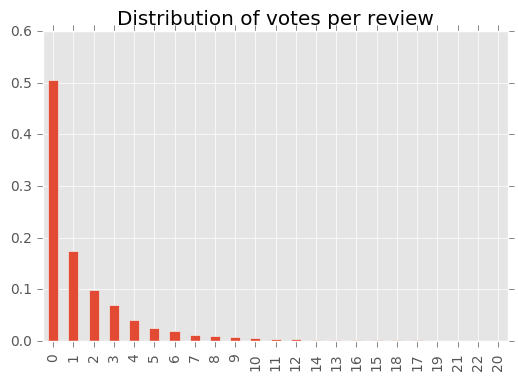

In [11]:
rbu['votes@reviews'].value_counts(normalize=True).ix[:20] \
    .plot.bar(rot=90, title='Distribution of votes per review')

### Investigate the distribution of ratings

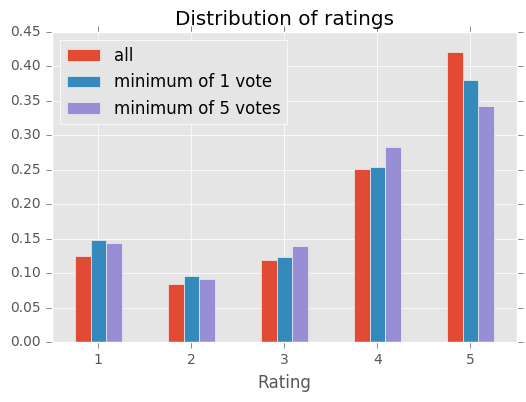

In [12]:
star_counts = rbu['stars@reviews'].value_counts(normalize=True).sort_index()
star_counts_min1 = rbu['stars@reviews'].loc[rbu['votes@reviews'] >= 1].value_counts(normalize=True).sort_index()
star_counts_min5 = rbu['stars@reviews'].loc[rbu['votes@reviews'] >= 5].value_counts(normalize=True).sort_index()

star_counts_comb = pd.concat([star_counts, star_counts_min1, star_counts_min5], axis=1)
star_counts_comb.columns = ['all', 'minimum of 1 vote', 'minimum of 5 votes']

star_counts_comb.plot.bar(title="Distribution of ratings", stacked=False, rot=0).set_xlabel('Rating')

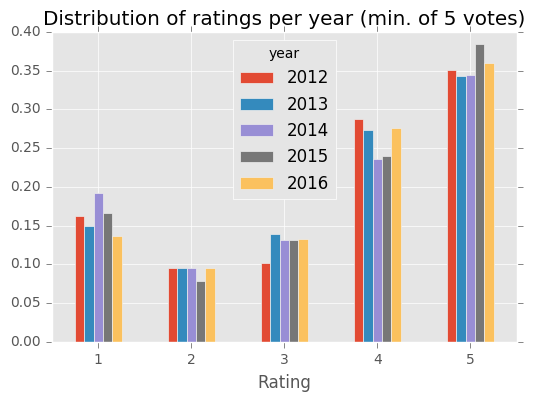

In [13]:
MIN_VOTES = 5
rbu_min_votes = rbu.loc[rbu['votes@reviews'] >= MIN_VOTES]

star_counts_per_year = rbu_min_votes.groupby(['year'])['stars@reviews'].value_counts(normalize=True).unstack().transpose()
star_counts_per_year[star_counts_per_year.columns[-5:]].plot.bar(title="Distribution of ratings per year (min. of {0} votes)".format(MIN_VOTES), stacked=False, rot=0).set_xlabel('Rating')

### Investigate correlations with the ratings column

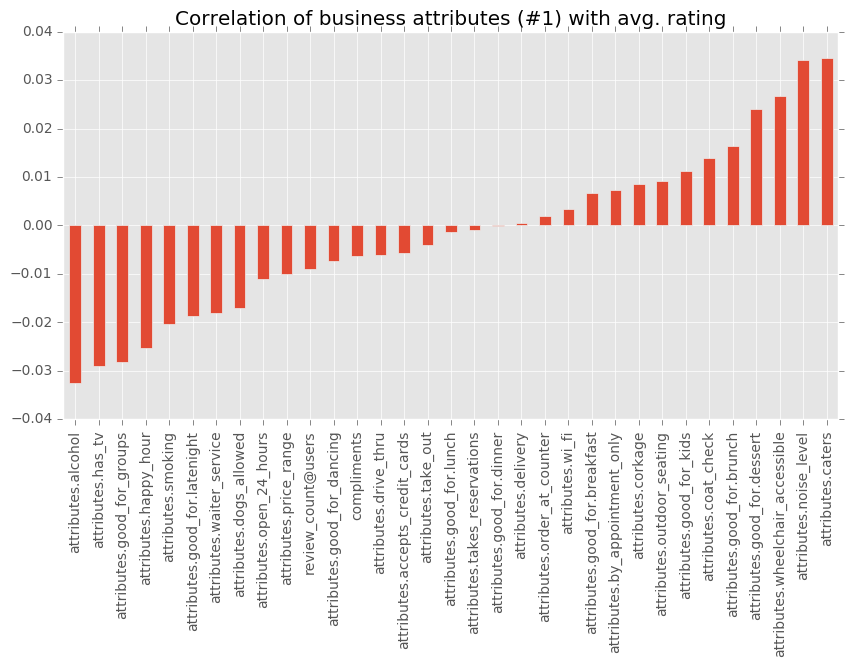

In [14]:
cols = ['attributes.accepts_credit_cards',
 'attributes.alcohol',
 'attributes.by_appointment_only',
 'attributes.caters',
 'attributes.coat_check',
 'attributes.corkage',
 'attributes.delivery',
 'attributes.dogs_allowed',
 'attributes.drive_thru'] \
  + [col for col in list(rbu) if col.startswith('attributes.good_for')] \
  + ['attributes.happy_hour',
 'attributes.has_tv',
 'attributes.noise_level',
 'attributes.open_24_hours',
 'attributes.order_at_counter',
 'attributes.outdoor_seating',
 'attributes.price_range',
 'attributes.smoking',
 'attributes.take_out',
 'attributes.takes_reservations',
 'attributes.waiter_service',
 'attributes.wheelchair_accessible',
 'attributes.wi_fi',
 'review_count@users',
 'compliments']
correls = rbu[cols].corrwith(rbu['stars@reviews'], drop=True).sort_values()
correls.plot.bar(figsize=(10,5), title='Correlation of business attributes (#1) with avg. rating')

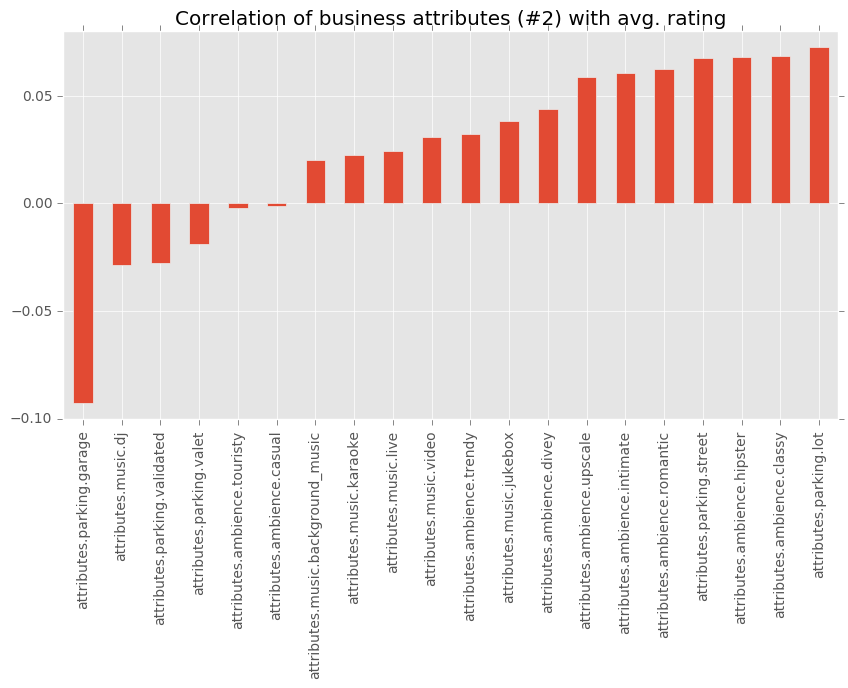

In [15]:
cols = [col for col in list(rbu) if re.search('(\.ambience|\.music|\.parking)', col)]
correls = rbu[cols].corrwith(rbu['stars@businesses'], drop=True).sort_values()
correls.plot.bar(figsize=(10,5), title='Correlation of business attributes (#2) with avg. rating')

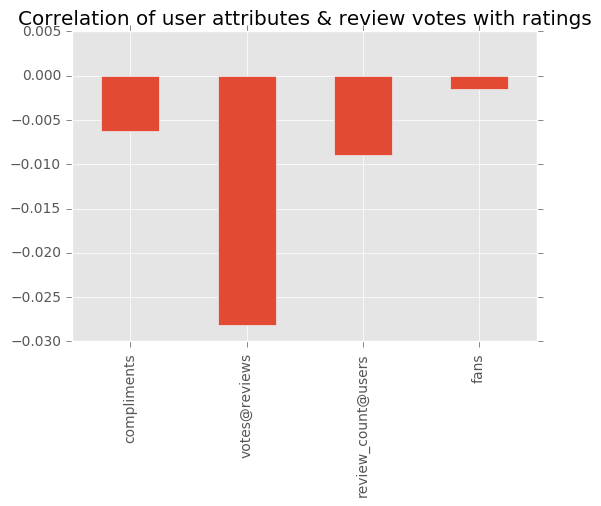

In [16]:
cols = ['compliments', 'votes@reviews', 'review_count@users', 'fans']
correls = rbu[cols].corrwith(rbu['stars@reviews'], drop=True)
correls.plot.bar(title='Correlation of user attributes & review votes with ratings')

In [17]:
# rbu.loc[rbu['votes'] >= 5].groupby(['stars_review'])['text_length'].mean().plot.bar(title="Mean review length (characters) vs. rating (min. of 5 votes)", stacked=False, rot=0).set_xlabel('Rating')

### Investigate the relation between review word count and rating

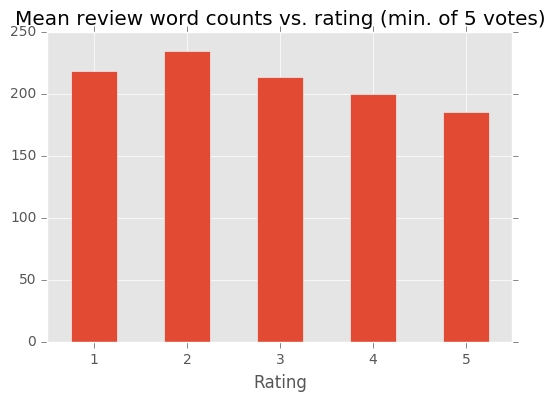

In [18]:
rbu.loc[rbu['votes@reviews'] >= MIN_VOTES].groupby(['stars@reviews'])['text_wc'].mean().plot.bar(title="Mean review word counts vs. rating (min. of 5 votes)", stacked=False, rot=0).set_xlabel('Rating')

# Predictive Data Analysis
## Predict a rating from business/user attributes and the review text

### Split the available data into training and test set

In [64]:
data_train, data_test = train_test_split(rbu, test_size = 0.2)

attr_cols = [col for col in list(rbu) if re.match('(votes\..+@users|votes\..+@reviews|attributes\.|city)', col)]
text_col = 'text'
label_col = 'stars@reviews'

['votes.cool@reviews',
 'votes.funny@reviews',
 'votes.useful@reviews',
 'attributes.accepts_credit_cards',
 'attributes.accepts_insurance',
 'attributes.alcohol',
 'attributes.ambience.casual',
 'attributes.ambience.classy',
 'attributes.ambience.divey',
 'attributes.ambience.hipster',
 'attributes.ambience.intimate',
 'attributes.ambience.romantic',
 'attributes.ambience.touristy',
 'attributes.ambience.trendy',
 'attributes.ambience.upscale',
 'attributes.attire',
 'attributes.byob',
 'attributes.byob_corkage',
 'attributes.by_appointment_only',
 'attributes.caters',
 'attributes.coat_check',
 'attributes.corkage',
 'attributes.delivery',
 'attributes.dogs_allowed',
 'attributes.drive_thru',
 'attributes.good_for_dancing',
 'attributes.good_for_groups',
 'attributes.good_for.breakfast',
 'attributes.good_for.brunch',
 'attributes.good_for.dessert',
 'attributes.good_for.dinner',
 'attributes.good_for.latenight',
 'attributes.good_for.lunch',
 'attributes.good_for_kids',
 'attributes

### Vectorize the review texts

In [20]:
# train the vectorizer from training data (review texts)
vect = CountVectorizer(
    stop_words='english',
    ngram_range=(1, 1),
    strip_accents='unicode',
    max_df=0.8,
    min_df=3,
    max_features=100000
)
vect.fit(data_train[text_col])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=100000, min_df=3,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

### Prepare features and labels

In [33]:
# collect features
X_train_attr = data_train[attr_cols]
X_test_attr = data_test[attr_cols]
#X_train_attr = pd.get_dummies( data_train[attr_cols] )
#X_test_attr = pd.get_dummies( data_test[attr_cols] )

X_train_dtm = vect.transform(data_train[text_col])
X_test_dtm = vect.transform(data_test[text_col])

# collect labels
y_train = data_train[label_col]
y_test = data_test[label_col]

In [34]:
# combine attribute matrices and sparse document-term matrices
X_train = sp.sparse.hstack((X_train_dtm, X_train_attr))
X_test = sp.sparse.hstack((X_test_dtm, X_test_attr))

### Multinomial Naive Bayes

In [42]:
# use a Multinomial Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [43]:
# make class predictions for X_test_dtm
y_pred = nb.predict(X_test_dtm)

In [44]:
# calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred)

0.57355957486481446

In [45]:
# calculate the mean error (more meaningful in our case)
metrics.mean_absolute_error(y_test, y_pred)

0.59584187954503076

In [46]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred)

array([[ 939,  257,   90,   50,   35],
       [ 230,  255,  248,  129,   42],
       [ 105,  123,  387,  505,   96],
       [ 123,   40,  245, 1528,  804],
       [ 224,   31,   88, 1109, 3043]])

In [47]:
# examine how often tokens of our dictionary appear in each rating category
tokens = pd.DataFrame(
    {'token': vect.get_feature_names(),
     '1 star'  : nb.feature_count_[0, :] / nb.class_count_[0],
     '2 stars' : nb.feature_count_[1, :] / nb.class_count_[1],
     '3 stars' : nb.feature_count_[2, :] / nb.class_count_[2] ,
     '4 stars' : nb.feature_count_[3, :] / nb.class_count_[3] ,
     '5 stars' : nb.feature_count_[4, :] / nb.class_count_[4]}
).set_index('token')
tokens.sample(10, random_state=2)

,1 star,2 stars,3 stars,4 stars,5 stars
token,,,,,
stamps,0.000189,0.000276,0.000386,0.000186,0.000664
tempt,0.000189,0.000276,0.000193,0.000093,0.000221
damn,0.008706,0.010497,0.007719,0.010509,0.006809
mentally,0.000757,0.000000,0.000193,0.000093,0.000277
acres,0.000000,0.000000,0.000193,0.000093,0.000055
tampa,0.000189,0.000000,0.000193,0.000093,0.000055
dissipated,0.000000,0.000276,0.000386,0.000000,0.000055
amazon,0.003028,0.001657,0.001158,0.000186,0.000664
inserted,0.000379,0.000276,0.000000,0.000000,0.000000


### Decision Tree

In [56]:
dtree = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=10)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [57]:
# make class predictions for X_test_dtm
y_pred = dtree.predict(X_test)

In [58]:
# calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred)

0.49300764497482752

In [59]:
# calculate the mean error
metrics.mean_absolute_error(y_test, y_pred)

0.94154391198955811

In [60]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred)

array([[ 458,   20,   39,  112,  742],
       [  88,   19,   78,  209,  510],
       [  50,   16,  130,  455,  565],
       [  27,   18,   92,  900, 1703],
       [  56,   18,   52,  588, 3781]])

### Support Vector Machine

In [ ]:
sv = SVC()
sv.fit(X_train_attr, y_train)

In [ ]:
# make class predictions for X_test_dtm
y_pred = sv.predict(X_test_att)

In [ ]:
# calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred)

In [ ]:
# calculate the mean error
metrics.mean_absolute_error(y_test, y_pred)

In [ ]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred)

## Ensemble Tests

### Gradient Booster Classifier

In [ ]:
gb = GradientBoostingClassifier(max_depth=5, n_estimators=1000)
gb.fit(X_train, y_train)

# make class predictions for X_test_dtm
y_pred = gb.predict(X_test)

In [ ]:
# calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred)

In [ ]:
# calculate the mean error
metrics.mean_absolute_error(y_test, y_pred)

In [ ]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred)

### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(n_estimators=1000, criterion='entropy', n_jobs=4, max_depth=10)
rf.fit(X_train_dtm, y_train)

# make class predictions for X_test_dtm
y_pred = rf.predict(X_test_dtm)

In [ ]:
# calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred)

In [ ]:
# calculate the mean error
metrics.mean_absolute_error(y_test, y_pred)

In [ ]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred)